# Importing Necessary Libraries

In [1]:
import numpy as np
import seaborn as sns
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
# import wikipedia sentences
candidate_sentences = pd.read_csv("/content/drive/MyDrive/Data_Science/Knowledge_Graph/wiki_sentences_v2.csv")
candidate_sentences.shape

(4318, 1)

In [4]:
# Checking out some few sentences
candidate_sentences['sentence'].sample(5)

4242                                       connors is being pressed by his superior, dr.
1940    sweeney's recent credits include the online interactive animation work, bla bla.
2555                              the film is scheduled to be released on may 6, 2022.\n
919                                  ptfe is often known by the dupont trademark teflon.
393             we were very conscious, the writer and i, that  was a metaphor for rape.
Name: sentence, dtype: object

In [5]:
# Checking out the Subject and Object of one of the sentences above

doc = nlp("the film is scheduled to be released on may 6, 2022.")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
film ... nsubjpass
is ... auxpass
scheduled ... ROOT
to ... aux
be ... auxpass
released ... xcomp
on ... prep
may ... pobj
6 ... nummod
, ... punct
2022 ... nummod
. ... punct


# Extracting the subject and object (Entities) from every sentence in the dataset

In [6]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    
    if tok.dep_ != "punct":
     
      if tok.dep_ == "compound":
        prefix = tok.text
        
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
 

  return [ent1.strip(), ent2.strip()]

In [7]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:37<00:00, 114.09it/s]


In [8]:
# Having a look at a few List entity Pairs
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['telepath', 'gallio'],
 ['singer', 'men']]

# Relation/Predicate Extraction

In [9]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [10]:
# Getting relations from all the wikipedia sentences
relations = [get_relation(i) for i in 
             tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:34<00:00, 124.56it/s]


In [11]:
# Checking out most frequent relations
pd.Series(relations).value_counts()[:50]

is               370
was              297
released on       87
include           73
were              71
are               71
released          40
's                38
composed by       35
became            31
has               31
have              31
become            29
released in       27
included          26
called            22
produced          22
made              20
had               20
considered        20
be                18
been              18
scheduled         17
used              17
directed by       16
stars             16
written by        15
wrote             14
set               14
hired             14
produced by       14
introduced in     13
received          13
went              13
wanted            12
began             11
began in          11
won               11
gave              10
sold              10
features          10
known as           9
directed           9
opened             9
shot in            9
used in            9
reported           9
gives        

# Building the Knowledge Graph


In [12]:
# extracting subject
source = [i[0] for i in entity_pairs]

# extracting object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [13]:
kg_df.head()

,source,target,edge
0,connie,own,decides
1,later woman,distance,heard in
2,christian,then elder,paralyzed by
3,temple,fire,set on
4,outside cult,him,wails with


# Using the Networkx library to create a network from the dataframe

In [14]:
# creating a directed-graph from the created dataframe dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

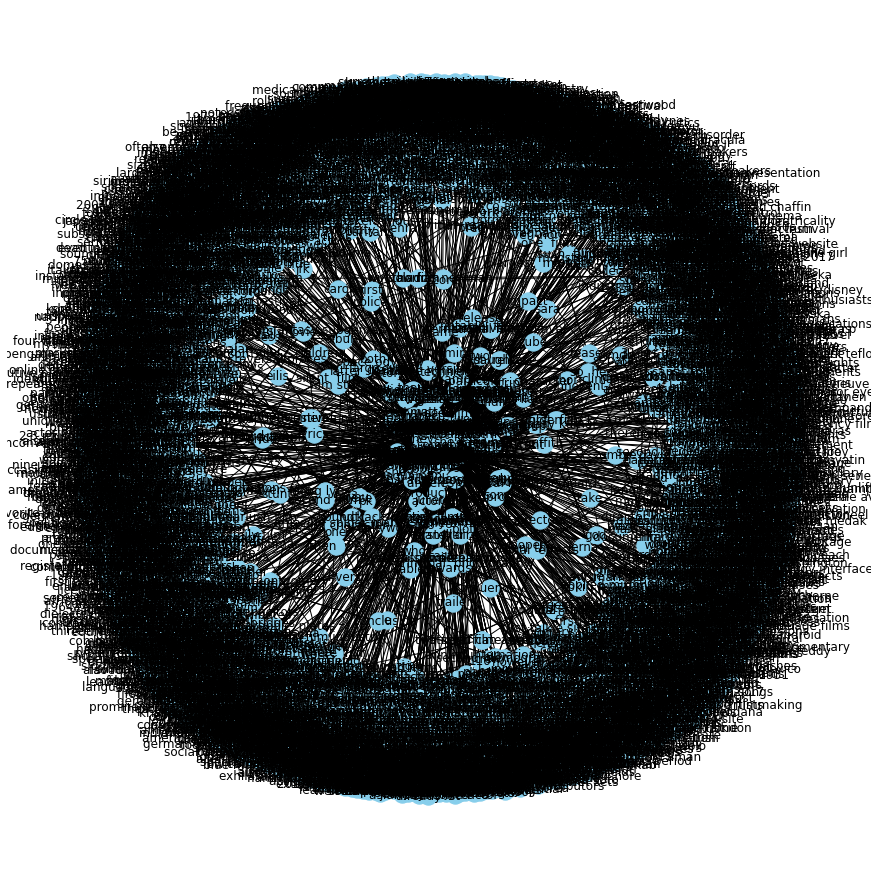

In [15]:
# An Attempt at plotting the network
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

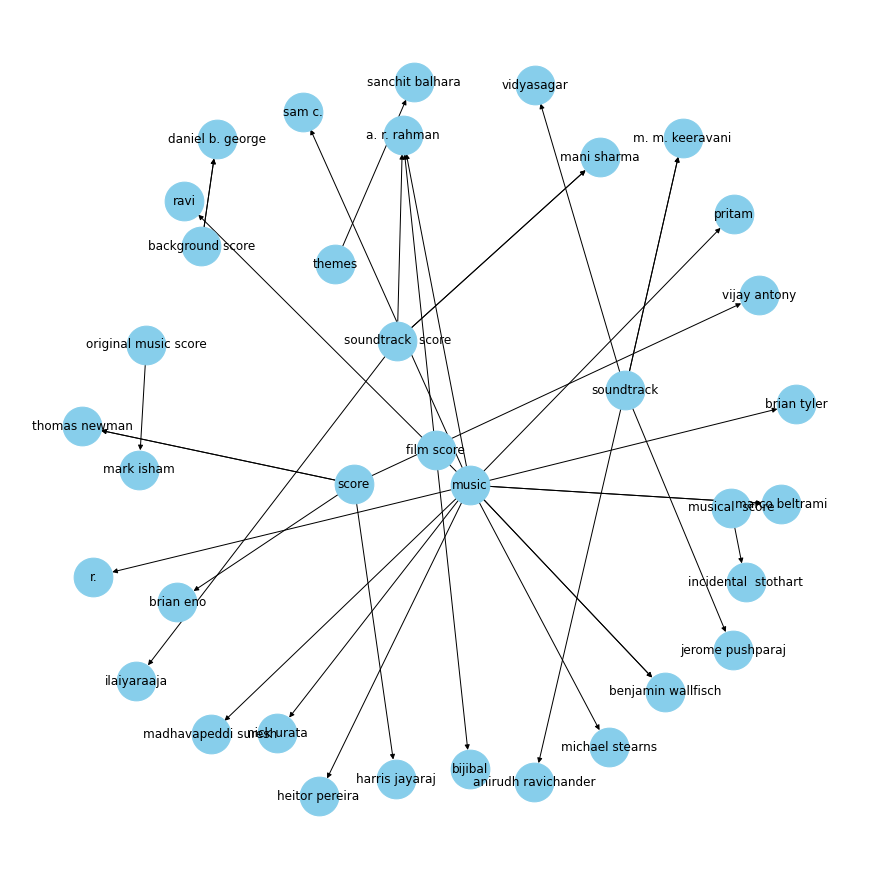

In [16]:
# Since we can't make so much sense of the network above, we can plot based on specific verbs
# Plotting based on Composed By
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

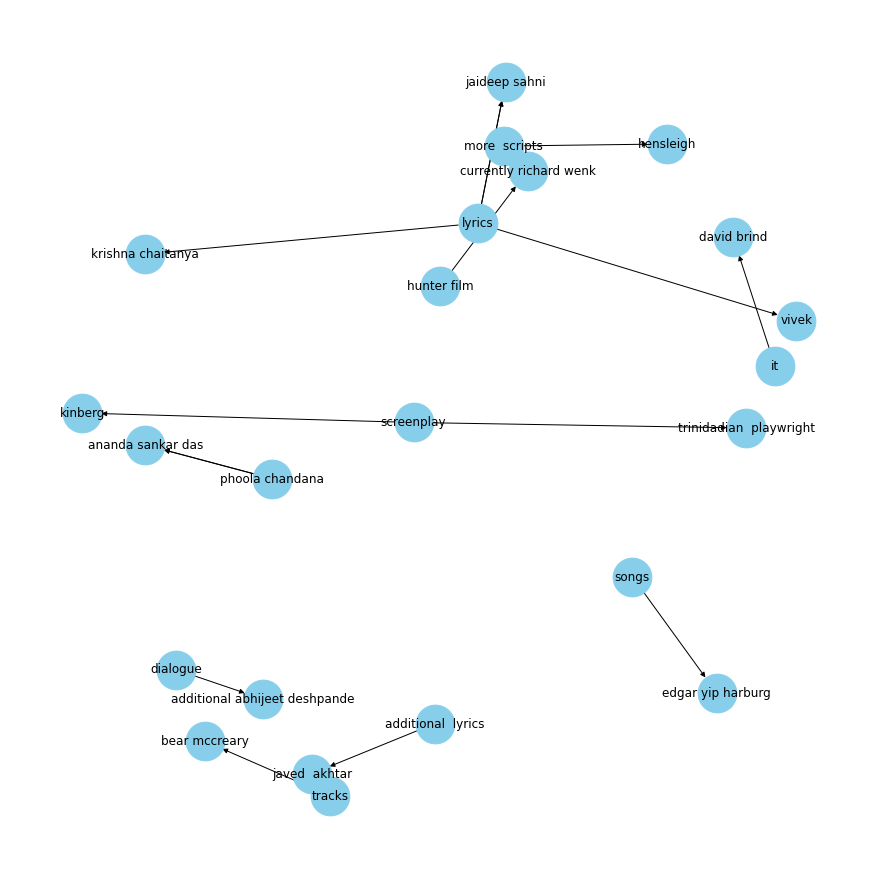

In [17]:
# Plotting network based on written by
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

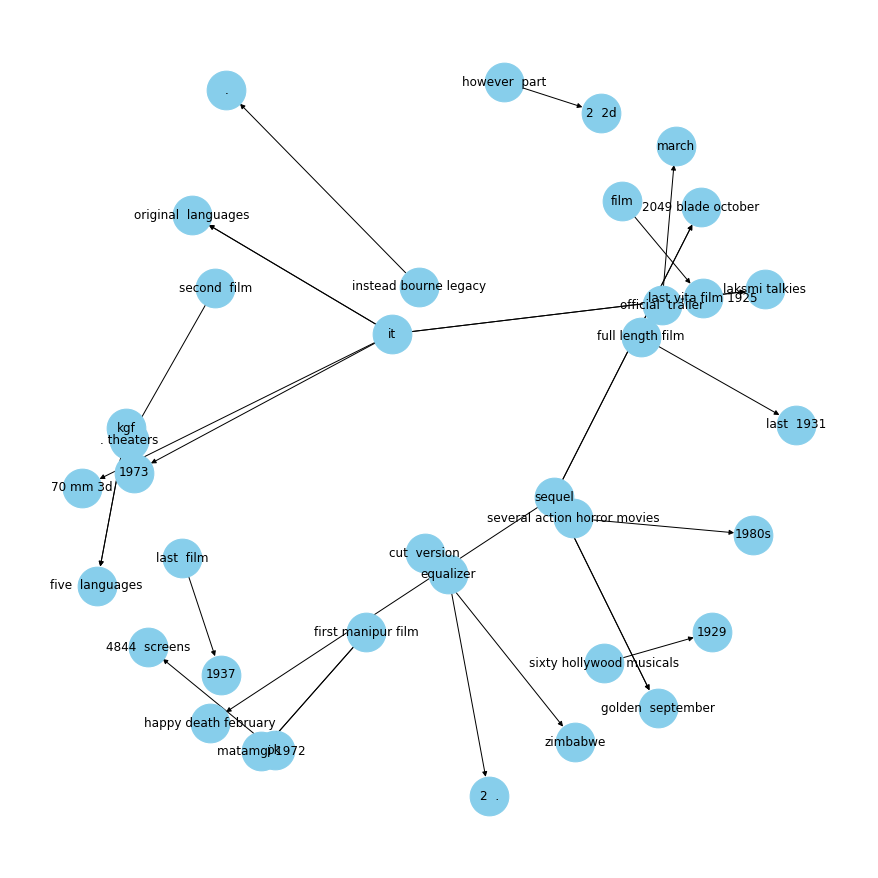

In [18]:
# Plotting for RELEASED IN
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

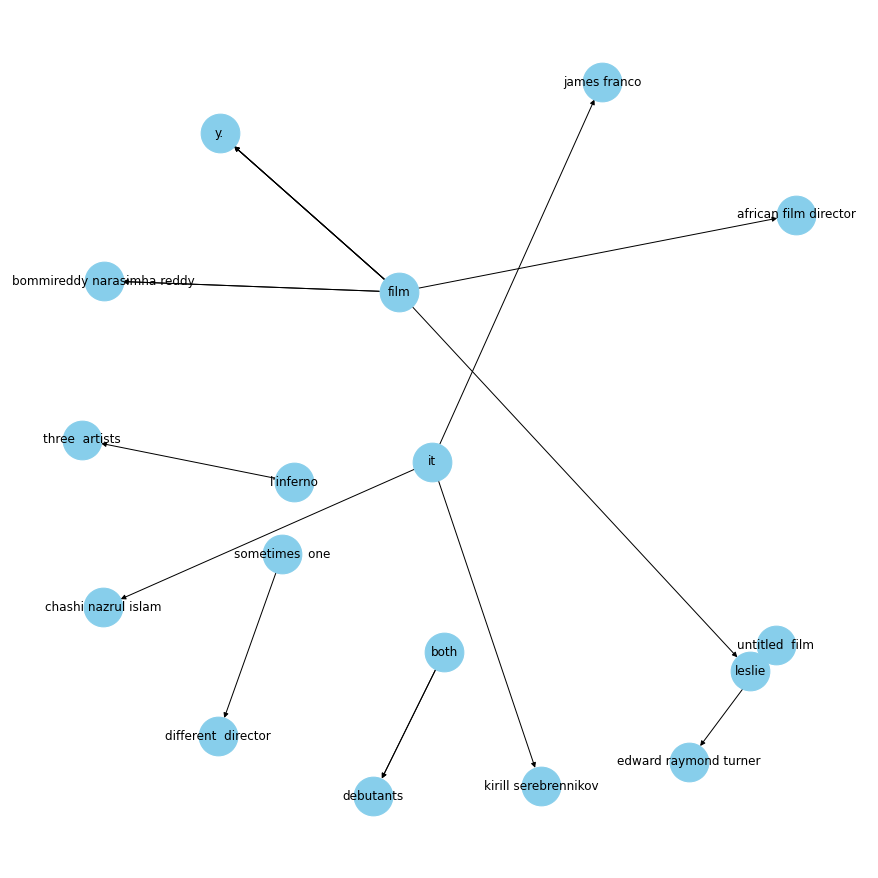

In [19]:
# Plotting for directed by
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="directed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()